# Batch processing using Joblib and Tqdm

In [1]:
from math import ceil
import random
import datetime
from joblib import Parallel, delayed

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm_batch import batch_process

sns.set_context('poster')

Simple batch processing function

In [2]:
def batch_process_function(row, order, payload):
    """
    Simulate process function
    
    Row and payload are ignored.
    
    Approximate pi
    """
    k, pi = 1, 0
    for i in range(10**6):
        if i % 2 == 0: # even
            pi += 4 / k
        else:  # odd 
            pi -= 4 / k 
        k += 2
    return pi

This function just calculates Pi:

In [3]:
batch_process_function('x', 6, None)

3.1415916535897743

Lets have some demo settings:

In [4]:
order=6
N = 1_000
items = range(N)

Process serially:

In [ ]:
%%time
result = [batch_process_function(row, order, None) for row in items]

In [ ]:
%%time
result = Parallel(n_jobs=8)(
    delayed(batch_process_function)
    (row, order, None) 
    for row in tqdm(items)
)

Serialization can increase the overhead such that it takes much longer than in a serial fashion:

In [ ]:
matrix = np.random.normal(size=(500, 500, 100))

In [ ]:
%%time
result = Parallel(n_jobs=8)(
    delayed(batch_process_function)
    (row, order, matrix) 
    for row in tqdm(items)
)

But working in batches, minimizing IO can bring us back on track:

In [ ]:
%%time

n_workers = 8

# Create a batch function
def proc_batch(batch, order, matrix):
    return [
        batch_process_function(row, order, matrix)
        for row in batch
    ]

# Divide data in batches
batch_size = ceil(len(items) / n_workers)
batches = [
    items[ix:ix+batch_size]
    for ix in range(0, len(items), batch_size)
]

# divide the work
result = Parallel(n_jobs=8)(
    delayed(proc_batch)
    (batch, order, matrix) 
    for batch in tqdm(batches)
)

This is all wrapped into the tqdm_batch package:

In [ ]:
result = batch_process(
    items,
    batch_process_function,
    order=6,
    n_workers=6,
    payload=matrix,
    sep_progress=True,
)

## How many CPUs are optimal?

In [5]:
%%time
result = []
for n_workers in range(1, 13):
    start = datetime.datetime.now()
    _ = batch_process(
        items,
        batch_process_function,
        order=6,
        n_workers=n_workers,
        payload=None,
        sep_progress=False,
    )
    dt = datetime.datetime.now() - start
    result.append({'workers': n_workers, 'time':dt})
    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1min 42s, sys: 877 ms, total: 1min 43s
Wall time: 7min 14s


In [6]:
df = pd.DataFrame(result)
df['dt'] = df.time.dt.total_seconds()

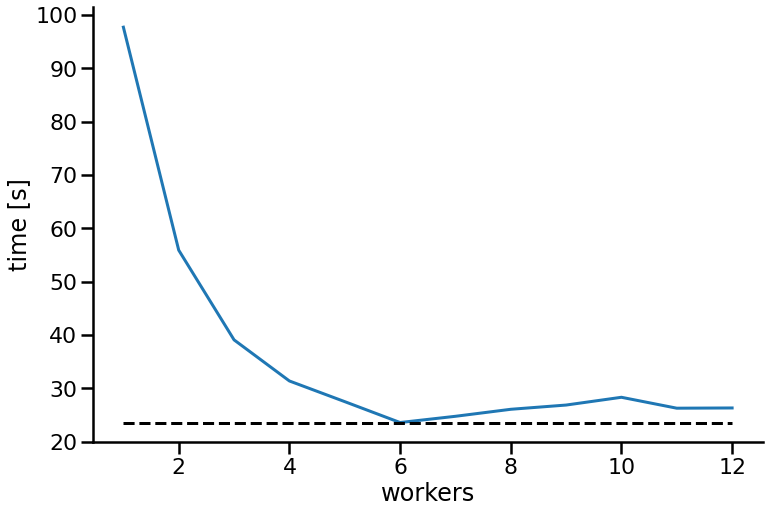

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='workers', y='dt', data=df, ax=ax)
ax.plot([1, 12], [df.dt.min(), df.dt.min()], 'k--')
_ = ax.set_ylabel('time [s]')
sns.despine()

In [8]:
fig.savefig('../assets/optimal_cpu.png', bbox_inches='tight')